In [31]:
from os import times
from pylsl import StreamInlet, resolve_stream
from datetime import datetime
from StreamReader import StreamReader
from Classifier import Classifier
import pandas as pd
from Experiment import Experiment
import time
import json
import os
import Filter
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import FastICA
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import math

In [32]:
sampleRate = 250

In [66]:
def loadDf(fileName):
    return pd.read_pickle(fileName)

def loadExpMetaData(fileName):
    trialData = []
    with open(fileName, 'r') as file:
        trialData = json.load(file)
    return trialData
def loadSubjectData(datadir, subjectName):
    subjects = os.listdir(datadir)
    subjectDir = datadir + "/" + subjectName 
    df = loadDf(subjectDir + "/" + subjectName + "Imagery.pkl")
    metaData = loadExpMetaData(subjectDir + "/" + subjectName + "ImageryMetadata.json")
    return df, metaData
    

In [130]:
rawData, metaData = loadSubjectData("C:/OpenBCI/MI_Project/Src/Stream/data", "Lizzie")

In [131]:
"""
Input : raw trial data as a df with timestamp
Returns : raw data in np format without timestamp, timestamp column of original df to save for later 
"""
def dropTimeStamps(df):
    dfNoTimeStamp = df.drop(["timestamp"], axis=1)
    dataArray = dfNoTimeStamp.to_numpy()
    nonTimeStampColumns = list(dfNoTimeStamp.columns.values)
    return dataArray, df[:]["timestamp"], list(dfNoTimeStamp.columns.values)

In [132]:
npData, timestamps, channelColumnNames = dropTimeStamps(rawData)

In [133]:
"""
Input: 
      - arr : numpy array containing raw session data
      - refChannel : eyeblink reference channel.
Operation:
      - performs ICA on the incoming channel
      - zeros the resultant channel that is most similar to the reference channel
      - performs inverse ICA to regain original source signal
Returns:
        - reconstructed signal source
"""
def removeEyeBlinkArtifacts(arr, refChannel):
    ica = FastICA(n_components=8)
    ica.fit(arr)
    components = ica.transform(arr)
    # subtract each component from the first channel and then take the power of the result (sum of each squared sample)
    # the component with the lowest resulting power should correspond to the "eye-blink" signal.
    # make this component 0s and then do an invers ICA transform
    eyeBlinkComponent = -1
    eyeBlinkComponetPower = 0
    i = 0
    for component in components.T:
        compDiff = arr.T[refChannel] - component
        compDiff = np.square(compDiff)
        compPower = np.sum(compDiff, 0) 
        if eyeBlinkComponent == -1 or compPower < eyeBlinkComponetPower:
            eyeBlinkComponetPower = compPower
            eyeBlinkComponent = i
        i+=1
    components = components.T
    components[eyeBlinkComponent] = 0
    components = components.T
    reconstructed = ica.inverse_transform(components)
    arr = reconstructed
    return arr
    
"""
Input: 
    - channel : signal to filter
Operation:
    - applies 2-250 hz bandpass and band stop around 60 hz to eliminate powerline noise
Returns:
    - filtered signal
"""
def filterChannel(channel):
    bandpassed = Filter.butter_bandpass_filter(channel, 2, 10, 250, 1)
    bandstopped = Filter.butter_bandstop_filter(bandpassed, 59, 61, 250, 1)
    return bandstopped

"""
Input: 
    - arr : multicahnnel input siganl
Operation:
    - applies 2-250 hz bandpass and band stop around 60 hz bandstop on each channel in the source signal
Returns:
    - filtered signal
"""
def filterData(arr):
    channelBySampleArray = arr.T
    numChannels = channelBySampleArray.shape[0]
    for i in range(numChannels):
        channelBySampleArray[i] = filterChannel(channelBySampleArray[i])
    return channelBySampleArray.T


In [134]:
npData = filterData(npData)
npData = removeEyeBlinkArtifacts(npData, 0)

C:\OpenBCI\MI_Project\MI_venv\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [135]:
def reconstructDf(npArr, timeStamp, channelColumnNames):
    newDf = pd.DataFrame(npArr, columns=channelColumnNames)
    newDf = newDf.assign(timestamp=timeStamp)
    return newDf

In [136]:
df = reconstructDf(npData, timestamps, channelColumnNames)

In [137]:
"""
Input: 
      - df : raw data from session
      - metadata : data tracking trial types and timestamps from the experiment
Operation:
      - splits the raw session data into trials 
      - all right handed trials are filled first
      - there are an equal number of trials 
Returns:
        - data in a NumTrials x NumSamples x NumChannels numpy array
"""
def splitRawDataIntoTrialsByType(df, metaData):
    rightTrials = []
    leftTrials = []
    for i in range(len(metaData)):
        trial = metaData[i]
        trialStartTimeValMask = df["timestamp"] == float(trial["trialStartTime"])
        trialStartIndex = df["timestamp"][trialStartTimeValMask].index.values[0]
        # make trial end time = trialStartTime + trialLength, so that we standardize triallengths
        # trial length is 1250 = 5 sec * 250 Hz
        trialEndIndex = trialStartIndex + 1250 
        trialDf = df.iloc[trialStartIndex:trialEndIndex,:]
        trialDf = trialDf.reset_index(drop=True)
        trialDf.drop('timestamp', axis=1, inplace=True) # no longer need timestamp
        if trial["trialType"] == "moveRight":
            rightTrials.append(trialDf)
        elif trial["trialType"] == "moveLeft":
            leftTrials.append(trialDf) 
    rightTrialsArray = np.array(rightTrials)
    leftTrialsArray = np.array(leftTrials)
    allData = np.concatenate((rightTrialsArray, leftTrialsArray))
    return allData

In [138]:
trialSplitData = splitRawDataIntoTrialsByType(df, metaData)

In [139]:
def scaleData(arr):
    scaler = preprocessing.StandardScaler()
    num_instances, num_time_steps, num_features = arr.shape
    arr = np.reshape(arr, newshape=(-1, num_features))
    arr = scaler.fit_transform(arr)
    arr = np.reshape(arr, newshape=(num_instances, num_time_steps, num_features))
    return scaler, arr
        

In [140]:
scaler, scaledTrialData = scaleData(trialSplitData)

In [148]:
def calculateAvgPowerforTrialType(arr, trialType):
    numTrials = arr.shape[0]
    numSamples = arr.shape[1]
    trialRange = range(math.floor(numTrials/2)) if trialType == "right" else range(math.floor(numTrials/2), numTrials)
    print(trialRange)
    freqAmplitudes = None
    freqs = None
    firstTime = True
    for i in trialRange:
        if firstTime:
            freqAmplitudes = np.abs(np.fft.fft(arr[i], axis=1))
            freqs = np.fft.fftfreq(n=numSamples, d=1/sampleRate)
            firstTime = False
        else:
            freqAmplitudes = np.add(freqAmplitudes, np.abs(np.fft.fft(arr[i], axis=1)))
    print(freqs.shape)
    print(freqAmplitudes.shape)
    freqs = freqs[:math.floor(len(freqs)/2)]
    freqAmplitudes = freqAmplitudes[:math.floor(len(freqAmplitudes)/2)]
    freqAmplitudes = freqAmplitudes / (numTrials/2)
    return freqs, freqAmplitudes

In [149]:
def plotFrequencyPowers(rfreqs, rfreqAmplitudes, lfreqs, lfreqAmplitudes, ax):
    ax.plot(rfreqs, rfreqAmplitudes, 'b')
    ax.plot(lfreqs, lfreqAmplitudes, 'r')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('FFT Amplitude |X(freq)|')
    ax.set_xlim(0, 40)
    ax.set_ylim(0,np.amax([np.amax(rfreqAmplitudes), np.amax(lfreqAmplitudes)]))

def plotFreqPowerForAllChannels(rfreqs, rfreqAmplitudes, lfreqs, lfreqAmplitudes):
    plt.close('all')
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    axes = []
    numChannels = rfreqAmplitudes.shape[1]
    for i in range(numChannels):
        rowIndex = 0 if i < 4 else 1
        colIndex = i % 4
        ax = plt.subplot2grid((2, 4), (rowIndex, colIndex))
        plotFrequencyPowers(rfreqs, rfreqAmplitudes[:, i], lfreqs, lfreqAmplitudes[:, i], ax)
        axes.append(ax)
    
    plt.tight_layout()
    plt.show()

range(0, 30)
(1250,)
(1250, 8)
range(30, 60)
(1250,)
(1250, 8)


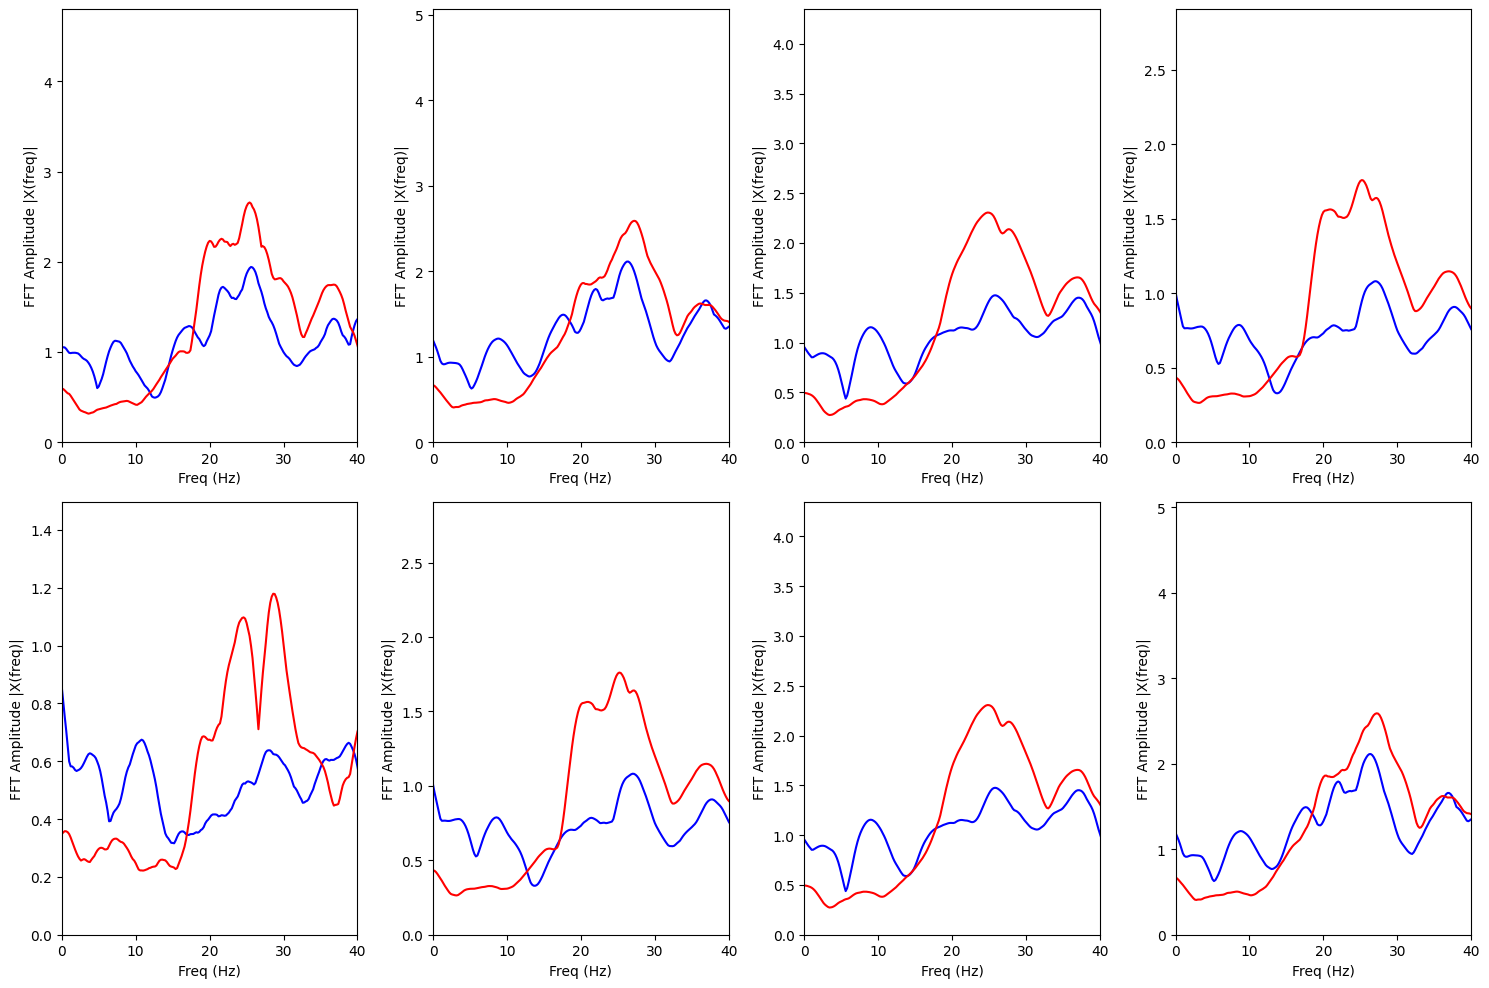

In [150]:
rightFreqs, rightFreqAmplitudes = calculateAvgPowerforTrialType(scaledTrialData, "right")
leftFreqs, leftFreqAmplitudes = calculateAvgPowerforTrialType(scaledTrialData, "left")


plotFreqPowerForAllChannels(rightFreqs, rightFreqAmplitudes, leftFreqs, leftFreqAmplitudes)

In [144]:
"""
Input: 
    - arr : array to estimate covariance of, in this case a timeseries of EEG data
Operation:
    - calculate to covariance of the matrix !
Returns:
    - covariance matrix
"""
def calculateCovarianceEstimate(arr):
    # covariance matrix is numChannels x numChannels
    covar = np.zeros(shape=(arr.shape[2], arr.shape[2]))
    numTrials = arr.shape[0]
    for trial in arr:
        covar += np.matmul(trial.T,trial)
    covar += 1/numTrials
    return covar

"""
Input:
    - A : matrix 1
    - B: matrix 2
Operation:
    - Calculates the generalized eigenvectors/values for A with respect to B
Returns:
    - list of eigen values and vectors, sorted by eigenvalue 
"""
def calculateGeneralizedEigenVectors(A, B):
    eigvals, eigvecs = eigh(A, B, eigvals_only=False)
    return eigvals, eigvecs

"""
Input:
    - eigvecs: list of eigenvectors
    - halfNumFilters: half the number of filtered channels we want (6)
Operation:
    - creates W filter for the incoming source signal
Returns: 
    - filter ! 
"""
def createFilter(eigvecs, halfNumFilters):
    filterCollector = []
    for i in range(len(eigvecs)):
        if (i < halfNumFilters or i >= len(eigvecs) - halfNumFilters):
            filterCollector.append(eigvecs[i])
    return np.array(filterCollector)

"""
Input:
    - filter: W filter 
    - arr: half the number of filtered channels we want (6)
Operation:
    - creates W filter for the incoming source signal
Returns: 
    - filter ! 
"""
def applySpatialFilter(filter, arr):
    arr = arr.T
    arr = np.matmul(filter, arr)
    arr = arr.T
    return arr

In [145]:
rightCovar = calculateCovarianceEstimate(scaledTrialData[:30])
leftCovar = calculateCovarianceEstimate(scaledTrialData[30:])
eigvals, eigvecs = calculateGeneralizedEigenVectors(rightCovar, leftCovar)
spatialFilter = createFilter(eigvecs, 3)

spatialFilteredTrials = []
for trial in scaledTrialData:
    spatialFilteredTrials.append(applySpatialFilter(spatialFilter, trial))
spatialFilteredTrials = np.array(spatialFilteredTrials)

(1250,)
(1250, 6)
(1250,)
(1250, 6)


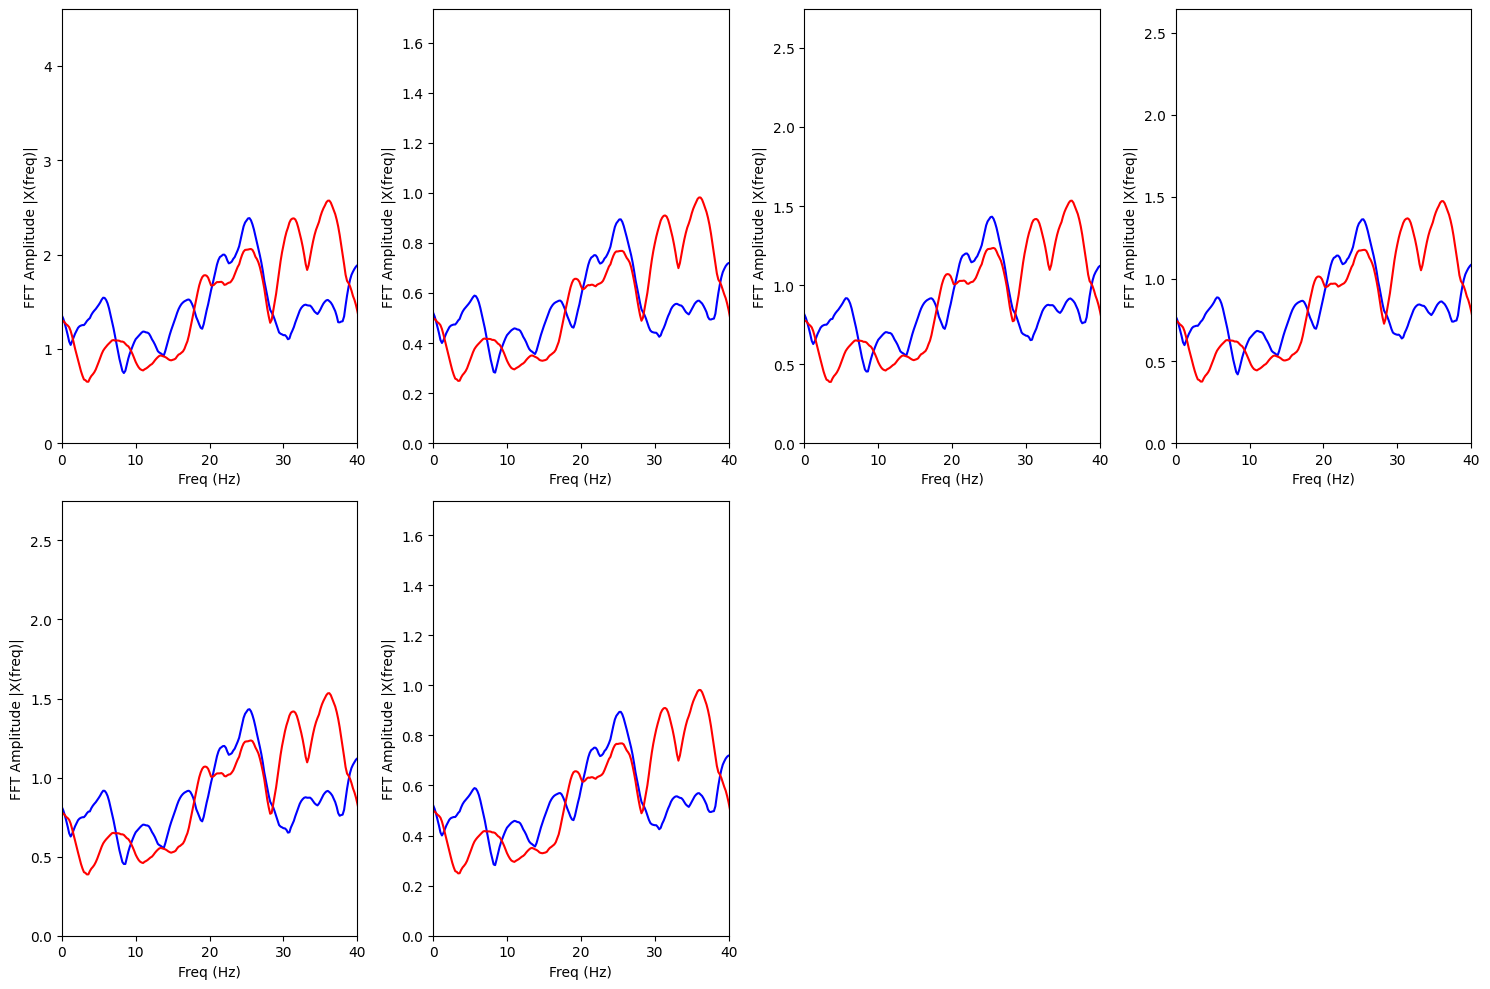

In [146]:
rightFreqs, rightFreqAmplitudes = calculateAvgPowerforTrialType(spatialFilteredTrials, "right")
leftFreqs, leftFreqAmplitudes = calculateAvgPowerforTrialType(spatialFilteredTrials, "left")


plotFreqPowerForAllChannels(rightFreqs, rightFreqAmplitudes, leftFreqs, leftFreqAmplitudes)